In [1]:
from bs4 import BeautifulSoup 
import requests
import pandas as pd
import numpy as np
import lxml.html as lh
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe
from sklearn.cluster import KMeans
import matplotlib.cm as cm
import matplotlib.colors as colors
from scipy.spatial.distance import cdist
from matplotlib import pyplot as plt
from sklearn.metrics import silhouette_samples, silhouette_score

%matplotlib inline

In [2]:
# Getting the table from Wikipedia and creating dataframe
url = "https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M"
source = requests.get(url).text
rawdata = BeautifulSoup(source,'lxml')
table =rawdata.find("table",class_="wikitable sortable")

column_names = [i.get_text() for i in table.tbody("tr")[0].find_all("th")[:]]
column_names= [i.replace("\n","") for i in column_names]
column_names

['Postcode', 'Borough', 'Neighbourhood']

The code below creates a dataframe after extracting relevant information from the table (in a html form) that was obtain from the previous step.  
Any row that has a "Not Assigned" value (under either the Borough or Neighborhood column) was deleted

In [3]:
# Still working on dataframe creation
table_data = [td.text  for j in range(1,len(table.tbody("tr")[:])-1) for td in rawdata.table('tr')[j]('td')]
post_code = table_data[0::3]
borough = table_data[1::3]
neighb = table_data[2::3]
df = pd.DataFrame({"PostalCode":post_code, "Borough":borough, "Neighborhood":neighb},
                  index=range(0,len(neighb)))
df.Neighborhood=  [ o.replace("\n","") for o in df.Neighborhood.values]
df = df[df!='Not assigned'].dropna().reset_index().drop("index", axis=1)
df.head(11)

,PostalCode,Borough,Neighborhood
0,M3A,North York,Parkwoods
1,M4A,North York,Victoria Village
2,M5A,Downtown Toronto,Harbourfront
3,M5A,Downtown Toronto,Regent Park
4,M6A,North York,Lawrence Heights
5,M6A,North York,Lawrence Manor
6,M9A,Etobicoke,Islington Avenue
7,M1B,Scarborough,Rouge
8,M1B,Scarborough,Malvern
9,M3B,North York,Don Mills North


In [4]:
df.shape

(211, 3)

A Helper function is being defined to change the list into a string containing all the element of the list

In [5]:
def fromList2Str(listtoconvert):
    l = len(listtoconvert)
    string = ""
    for i in listtoconvert:
        string = string + str(i)+", "
    return string[0:-2]

The dataframe is grouped such that the neighborhoods that have the same postal code are put together on the same row

In [6]:
gb =df.groupby(by=["PostalCode","Borough"])
df = gb["Neighborhood"].unique()
df = df.to_frame().reset_index()
df.Neighborhood = [fromList2Str(i) for i in df.Neighborhood.values]
df.head(30)

,PostalCode,Borough,Neighborhood
0,M1B,Scarborough,"Rouge, Malvern"
1,M1C,Scarborough,"Highland Creek, Rouge Hill, Port Union"
2,M1E,Scarborough,"Guildwood, Morningside, West Hill"
3,M1G,Scarborough,Woburn
4,M1H,Scarborough,Cedarbrae
5,M1J,Scarborough,Scarborough Village
6,M1K,Scarborough,"East Birchmount Park, Ionview, Kennedy Park"
7,M1L,Scarborough,"Clairlea, Golden Mile, Oakridge"
8,M1M,Scarborough,"Cliffcrest, Cliffside, Scarborough Village West"
9,M1N,Scarborough,"Birch Cliff, Cliffside West"


In [7]:
df.shape

(102, 3)

<h2>Second Exercise</h2>

The csv provided by the course instructor was used rather than using geocoder

In [8]:
df_coord = pd.read_csv("http://cocl.us/Geospatial_data")
df_coord.rename(columns={"Postal Code":"PostalCode"}, inplace=True)
df_coord.head()

,PostalCode,Latitude,Longitude
0,M1B,43.806686,-79.194353
1,M1C,43.784535,-79.160497
2,M1E,43.763573,-79.188711
3,M1G,43.770992,-79.216917
4,M1H,43.773136,-79.239476


The postal codes are used to match the neighborhood with their corresponding coordinates 

In [9]:
df_joined =df.set_index("PostalCode").join(df_coord.set_index("PostalCode")).reset_index()
df_joined.head(11)

,PostalCode,Borough,Neighborhood,Latitude,Longitude
0,M1B,Scarborough,"Rouge, Malvern",43.806686,-79.194353
1,M1C,Scarborough,"Highland Creek, Rouge Hill, Port Union",43.784535,-79.160497
2,M1E,Scarborough,"Guildwood, Morningside, West Hill",43.763573,-79.188711
3,M1G,Scarborough,Woburn,43.770992,-79.216917
4,M1H,Scarborough,Cedarbrae,43.773136,-79.239476
5,M1J,Scarborough,Scarborough Village,43.744734,-79.239476
6,M1K,Scarborough,"East Birchmount Park, Ionview, Kennedy Park",43.727929,-79.262029
7,M1L,Scarborough,"Clairlea, Golden Mile, Oakridge",43.711112,-79.284577
8,M1M,Scarborough,"Cliffcrest, Cliffside, Scarborough Village West",43.716316,-79.239476
9,M1N,Scarborough,"Birch Cliff, Cliffside West",43.692657,-79.264848


<h2>Third Exercise</h2>

<h3>Explore and cluster the neighborhoods in Toronto</h3>

For the sake of simplicity, the borough only containing the word Toronto in their name are kept

In [10]:
# Dataset reduction to only Boroughs that contain the word Toronto 
mask = ["Toronto" in i for i in df_joined.Borough]
df_Toronto = df_joined[mask]
df_Toronto.head(10)

,PostalCode,Borough,Neighborhood,Latitude,Longitude
37,M4E,East Toronto,The Beaches,43.676357,-79.293031
41,M4K,East Toronto,"The Danforth West, Riverdale",43.679557,-79.352188
42,M4L,East Toronto,"The Beaches West, India Bazaar",43.668999,-79.315572
43,M4M,East Toronto,Studio District,43.659526,-79.340923
44,M4N,Central Toronto,Lawrence Park,43.728020,-79.388790
45,M4P,Central Toronto,Davisville North,43.712751,-79.390197
46,M4R,Central Toronto,North Toronto West,43.715383,-79.405678
47,M4S,Central Toronto,Davisville,43.704324,-79.388790
48,M4T,Central Toronto,"Moore Park, Summerhill East",43.689574,-79.383160
49,M4V,Central Toronto,"Deer Park, Forest Hill SE, Rathnelly, South Hi...",43.686412,-79.400049


In [11]:
df_Toronto.shape

(38, 5)

In [12]:
import folium
from geopy.geocoders import Nominatim

In [13]:
address = 'Toronto, ON'

geolocator = Nominatim(user_agent="foursquare_agent")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Toronto are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Toronto are 43.653963, -79.387207.


In [14]:
map_Toronto = folium.Map(location=[latitude, longitude], zoom_start=12)

# add markers to map
for lat, lng, borough, neighborhood in zip(df_Toronto['Latitude'], 
                                           df_Toronto['Longitude'],
                                           df_Toronto['Borough'],
                                           df_Toronto['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_Toronto)  
    
map_Toronto

#### Define Foursquare Credentials and Version

In [15]:
CLIENT_ID = 'XWFNS42WLQXVD3NKR1POHR2C0EFGH51MW5JGHFSJJEH3GNX5' # your Foursquare ID
CLIENT_SECRET = 'CWD2QWIQDVNOCTD1YR5KUYSIOWFK11RADQLW11YMMPMPI2LC' # your Foursquare Secret
VERSION = '20180604' # Foursquare API version

### Exploring Toronto Neighborhoods

In order to explore the neighborhoods, a max of 100 venues in a 500 meter radius of each neighborhood will be collected

In [16]:
LIMIT=100
radius = 500

In [17]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [18]:
toronto_venues = getNearbyVenues(names=df_Toronto['Neighborhood'],
                                   latitudes=df_Toronto['Latitude'],
                                   longitudes=df_Toronto['Longitude']
                                  )

The Beaches
The Danforth West, Riverdale
The Beaches West, India Bazaar
Studio District
Lawrence Park
Davisville North
North Toronto West
Davisville
Moore Park, Summerhill East
Deer Park, Forest Hill SE, Rathnelly, South Hill, Summerhill West
Rosedale
Cabbagetown, St. James Town
Church and Wellesley
Harbourfront, Regent Park
Ryerson, Garden District
St. James Town
Berczy Park
Central Bay Street
Adelaide, King, Richmond
Harbourfront East, Toronto Islands, Union Station
Design Exchange, Toronto Dominion Centre
Commerce Court, Victoria Hotel
Roselawn
Forest Hill North, Forest Hill West
The Annex, North Midtown, Yorkville
Harbord, University of Toronto
Chinatown, Grange Park, Kensington Market
CN Tower, Bathurst Quay, Island airport, Harbourfront West, King and Spadina, Railway Lands, South Niagara
Stn A PO Boxes 25 The Esplanade
First Canadian Place, Underground city
Christie
Dovercourt Village, Dufferin
Little Portugal, Trinity
Brockton, Exhibition Place, Parkdale Village
High Park, The 

In [19]:
print(toronto_venues.shape)
toronto_venues.head()

(1696, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,The Beaches,43.676357,-79.293031,The Big Carrot Natural Food Market,43.678879,-79.297734,Health Food Store
1,The Beaches,43.676357,-79.293031,Grover Pub and Grub,43.679181,-79.297215,Pub
2,The Beaches,43.676357,-79.293031,Starbucks,43.678798,-79.298045,Coffee Shop
3,The Beaches,43.676357,-79.293031,Upper Beaches,43.680563,-79.292869,Neighborhood
4,"The Danforth West, Riverdale",43.679557,-79.352188,Pantheon,43.677621,-79.351434,Greek Restaurant


Count the number of venues retrieved for each neighborhood

In [20]:
toronto_venues.groupby('Neighborhood')["Venue"].count()

Neighborhood
Adelaide, King, Richmond                                                                                      100
Berczy Park                                                                                                    56
Brockton, Exhibition Place, Parkdale Village                                                                   20
Business Reply Mail Processing Centre 969 Eastern                                                              17
CN Tower, Bathurst Quay, Island airport, Harbourfront West, King and Spadina, Railway Lands, South Niagara     13
Cabbagetown, St. James Town                                                                                    46
Central Bay Street                                                                                             81
Chinatown, Grange Park, Kensington Market                                                                     100
Christie                                                                   

In [21]:
print('There are {} uniques categories.'.format(len(toronto_venues['Venue Category'].unique())))

There are 236 uniques categories.


Retrieving the venue category and using onehot encoding to specify what venue categories are present for a given neighborhood

In [22]:
# one hot encoding
toronto_onehot = pd.get_dummies(toronto_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
toronto_onehot['Neighborhood'] = toronto_venues['Neighborhood']
mask = toronto_onehot.columns=="Neighborhood"

# move neighborhood column to the first column
fixed_columns = [toronto_onehot.columns[mask][0]] + list(toronto_onehot.drop("Neighborhood", axis=1).columns[:-1])
toronto_onehot = toronto_onehot[fixed_columns]

toronto_onehot.head()

,Neighborhood,Adult Boutique,Afghan Restaurant,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,...,Toy / Game Store,Trail,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Wine Bar,Wine Shop,Wings Joint,Women's Store
0,The Beaches,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,The Beaches,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,The Beaches,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,The Beaches,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,"The Danforth West, Riverdale",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [23]:
toronto_onehot.shape

(1696, 235)

Averaging the frequency of appearance of a given venue category for each neighborhoods. This help see what are the most categories in a given neighborhood.

In [24]:
toronto_grouped = toronto_onehot.groupby('Neighborhood').mean().reset_index()
toronto_grouped

,Neighborhood,Adult Boutique,Afghan Restaurant,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,...,Toy / Game Store,Trail,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Wine Bar,Wine Shop,Wings Joint,Women's Store
0,"Adelaide, King, Richmond",0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.030000,...,0.000000,0.000000,0.00,0.010000,0.000000,0.000000,0.010000,0.000000,0.000000,0.01
1,Berczy Park,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00
2,"Brockton, Exhibition Place, Parkdale Village",0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00
3,Business Reply Mail Processing Centre 969 Eastern,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00
4,"CN Tower, Bathurst Quay, Island airport, Harbo...",0.000000,0.000000,0.076923,0.076923,0.076923,0.153846,0.153846,0.153846,0.000000,...,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00
5,"Cabbagetown, St. James Town",0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00
6,Central Bay Street,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.012346,...,0.000000,0.000000,0.00,0.012346,0.000000,0.000000,0.012346,0.000000,0.000000,0.00
7,"Chinatown, Grange Park, Kensington Market",0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.010000,0.000000,0.00,0.050000,0.000000,0.040000,0.010000,0.000000,0.000000,0.00
8,Christie,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00
9,Church and Wellesley,0.011494,0.011494,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.011494,...,0.000000,0.000000,0.00,0.000000,0.011494,0.011494,0.000000,0.011494,0.011494,0.00


In [25]:
toronto_onehot.shape

(1696, 235)

In [26]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

Append the 10 most common venue categories to each neighborhood.

In [27]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = toronto_grouped['Neighborhood']

for ind in np.arange(toronto_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(toronto_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,"Adelaide, King, Richmond",Coffee Shop,Café,Bar,Steakhouse,Thai Restaurant,Bakery,Burger Joint,Restaurant,Gym,Hotel
1,Berczy Park,Coffee Shop,Cocktail Bar,Restaurant,Café,Cheese Shop,Seafood Restaurant,Italian Restaurant,Pub,Bakery,Steakhouse
2,"Brockton, Exhibition Place, Parkdale Village",Breakfast Spot,Café,Coffee Shop,Nightclub,Burrito Place,Stadium,Caribbean Restaurant,Bar,Italian Restaurant,Furniture / Home Store
3,Business Reply Mail Processing Centre 969 Eastern,Pizza Place,Garden,Comic Shop,Recording Studio,Restaurant,Burrito Place,Brewery,Skate Park,Smoke Shop,Farmers Market
4,"CN Tower, Bathurst Quay, Island airport, Harbo...",Airport Lounge,Airport Service,Airport Terminal,Plane,Harbor / Marina,Airport,Airport Food Court,Airport Gate,Boat or Ferry,Sculpture Garden


The elbow method is used to determine an optimal number of clusters from 1-10

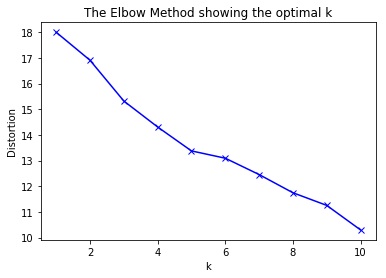

In [28]:
toronto_grouped_clustering = toronto_grouped.drop('Neighborhood', 1)
distortions=[]
silhouette_score_matrix = []
K=np.arange(1,11)
for k in K:
    kmeanModel = KMeans(n_clusters=k, random_state=2).fit(toronto_grouped_clustering)
    distortions.append(sum(np.min(cdist(toronto_grouped_clustering, kmeanModel.cluster_centers_, 'cosine'), axis=1))) 
    clusterlabels =kmeanModel.labels_
    if k >1:
        silhouette_avg = silhouette_score(toronto_grouped_clustering, clusterlabels)
        silhouette_score_matrix.append(silhouette_avg)

# Plot the elbow
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

It seems like there is a diminishing return starting from k=5, five clusters where then using for KMeans

In [29]:
# set number of clusters
kclusters = 5

toronto_grouped_clustering = toronto_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(toronto_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [30]:
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

toronto_merged = df_Toronto[1:]

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
toronto_merged = toronto_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

toronto_merged.head() # check the last columns!

,PostalCode,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
41,M4K,East Toronto,"The Danforth West, Riverdale",43.679557,-79.352188,0,Greek Restaurant,Coffee Shop,Ice Cream Shop,Italian Restaurant,Bookstore,Cosmetics Shop,Indian Restaurant,Liquor Store,Bubble Tea Shop,Brewery
42,M4L,East Toronto,"The Beaches West, India Bazaar",43.668999,-79.315572,0,Sandwich Place,Park,Gym,Steakhouse,Sushi Restaurant,Food & Drink Shop,Brewery,Ice Cream Shop,Pub,Movie Theater
43,M4M,East Toronto,Studio District,43.659526,-79.340923,0,Café,Coffee Shop,Italian Restaurant,Bakery,American Restaurant,Gastropub,Cheese Shop,Juice Bar,Bookstore,Fish Market
44,M4N,Central Toronto,Lawrence Park,43.728020,-79.388790,4,Park,Bus Line,Swim School,Women's Store,Dog Run,Fast Food Restaurant,Farmers Market,Falafel Restaurant,Event Space,Ethiopian Restaurant
45,M4P,Central Toronto,Davisville North,43.712751,-79.390197,0,Breakfast Spot,Hotel,Sandwich Place,Food & Drink Shop,Clothing Store,Dance Studio,Dog Run,Burger Joint,Park,Gym


In [31]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(toronto_merged['Latitude'], toronto_merged['Longitude'],
                                  toronto_merged['Neighborhood'],
                                  toronto_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

In [32]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 0,
                     toronto_merged.columns[[2] + list(range(5, toronto_merged.shape[1]))]]

,Neighborhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
41,"The Danforth West, Riverdale",0,Greek Restaurant,Coffee Shop,Ice Cream Shop,Italian Restaurant,Bookstore,Cosmetics Shop,Indian Restaurant,Liquor Store,Bubble Tea Shop,Brewery
42,"The Beaches West, India Bazaar",0,Sandwich Place,Park,Gym,Steakhouse,Sushi Restaurant,Food & Drink Shop,Brewery,Ice Cream Shop,Pub,Movie Theater
43,Studio District,0,Café,Coffee Shop,Italian Restaurant,Bakery,American Restaurant,Gastropub,Cheese Shop,Juice Bar,Bookstore,Fish Market
45,Davisville North,0,Breakfast Spot,Hotel,Sandwich Place,Food & Drink Shop,Clothing Store,Dance Studio,Dog Run,Burger Joint,Park,Gym
46,North Toronto West,0,Coffee Shop,Clothing Store,Sporting Goods Shop,Gym / Fitness Center,Italian Restaurant,Park,Chinese Restaurant,Dessert Shop,Diner,Rental Car Location
47,Davisville,0,Sandwich Place,Dessert Shop,Pizza Place,Sushi Restaurant,Italian Restaurant,Restaurant,Café,Coffee Shop,Pharmacy,Greek Restaurant
49,"Deer Park, Forest Hill SE, Rathnelly, South Hi...",0,Pub,Coffee Shop,Pizza Place,American Restaurant,Supermarket,Sushi Restaurant,Fried Chicken Joint,Sports Bar,Spa,Vietnamese Restaurant
51,"Cabbagetown, St. James Town",0,Coffee Shop,Restaurant,Pizza Place,Bakery,Café,Italian Restaurant,Pub,Park,Pharmacy,Butcher
52,Church and Wellesley,0,Coffee Shop,Japanese Restaurant,Sushi Restaurant,Gay Bar,Restaurant,Café,Mediterranean Restaurant,Men's Store,Burger Joint,Gastropub
53,"Harbourfront, Regent Park",0,Coffee Shop,Park,Bakery,Pub,Café,Breakfast Spot,Mexican Restaurant,Theater,Brewery,Electronics Store


In [33]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 1,
                     toronto_merged.columns[[2] + list(range(5, toronto_merged.shape[1]))]]

,Neighborhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
48,"Moore Park, Summerhill East",1,Playground,Summer Camp,Women's Store,Discount Store,Fast Food Restaurant,Farmers Market,Falafel Restaurant,Event Space,Ethiopian Restaurant,Electronics Store


In [34]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 2,
                     toronto_merged.columns[[2] + list(range(5, toronto_merged.shape[1]))]]

,Neighborhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
50,Rosedale,2,Park,Playground,Trail,Women's Store,Diner,Farmers Market,Falafel Restaurant,Event Space,Ethiopian Restaurant,Electronics Store


In [35]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 3,
                     toronto_merged.columns[[2] + list(range(5, toronto_merged.shape[1]))]]

,Neighborhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
63,Roselawn,3,Music Venue,Home Service,Garden,Women's Store,Fast Food Restaurant,Farmers Market,Falafel Restaurant,Event Space,Ethiopian Restaurant,Electronics Store


In [36]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 4,
                     toronto_merged.columns[[2] + list(range(5, toronto_merged.shape[1]))]]

,Neighborhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
44,Lawrence Park,4,Park,Bus Line,Swim School,Women's Store,Dog Run,Fast Food Restaurant,Farmers Market,Falafel Restaurant,Event Space,Ethiopian Restaurant


Insight from the clusters reveal that:  
<ul><li>Cluster 0: contain places more relevant to social interactions and to productivity</li>
    <li>Cluster 1: contain place more driven by activities to be done with children</li> 
    <li>Cluster 2: is similar to cluster 1 but contain activites where children might not be wanted (trail)</li> 
    <li>Cluster 3: is similar to cluster 1 except for the most common venues that are tailored towards adults only</li> 
    <li>Cluster 4: Again similar to cluster , except for the Bus line and Parks</li>  
</ul>  
Because of all these similarities in clusters 1 through 4, I actually ended up creating 3 clusters (see below). Where:  
<ul><li>Cluster 0 corresponds to neighborhood that seem more relevant for familiy with kids</li>
    <li>Cluster 1 corresponds to more everyday social places associated with productivity</li> 
    <li>Cluster 2 corresponds to more weekend type of venues that families can go to</li>
   </ul>

In [37]:
# set number of clusters
kclusters = 3

toronto_grouped_clustering = toronto_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(toronto_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [38]:
# add clustering labels
neighborhoods_venues_sorted['Cluster Labels']= kmeans.labels_

toronto_merged = df_Toronto[1:]

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
toronto_merged = toronto_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

toronto_merged.head() # check the last columns!

,PostalCode,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
41,M4K,East Toronto,"The Danforth West, Riverdale",43.679557,-79.352188,1,Greek Restaurant,Coffee Shop,Ice Cream Shop,Italian Restaurant,Bookstore,Cosmetics Shop,Indian Restaurant,Liquor Store,Bubble Tea Shop,Brewery
42,M4L,East Toronto,"The Beaches West, India Bazaar",43.668999,-79.315572,1,Sandwich Place,Park,Gym,Steakhouse,Sushi Restaurant,Food & Drink Shop,Brewery,Ice Cream Shop,Pub,Movie Theater
43,M4M,East Toronto,Studio District,43.659526,-79.340923,1,Café,Coffee Shop,Italian Restaurant,Bakery,American Restaurant,Gastropub,Cheese Shop,Juice Bar,Bookstore,Fish Market
44,M4N,Central Toronto,Lawrence Park,43.728020,-79.388790,2,Park,Bus Line,Swim School,Women's Store,Dog Run,Fast Food Restaurant,Farmers Market,Falafel Restaurant,Event Space,Ethiopian Restaurant
45,M4P,Central Toronto,Davisville North,43.712751,-79.390197,1,Breakfast Spot,Hotel,Sandwich Place,Food & Drink Shop,Clothing Store,Dance Studio,Dog Run,Burger Joint,Park,Gym


In [39]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(toronto_merged['Latitude'], toronto_merged['Longitude'],
                                  toronto_merged['Neighborhood'],
                                  toronto_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

In [40]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 0,
                     toronto_merged.columns[[2] + list(range(5, toronto_merged.shape[1]))]]

,Neighborhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
48,"Moore Park, Summerhill East",0,Playground,Summer Camp,Women's Store,Discount Store,Fast Food Restaurant,Farmers Market,Falafel Restaurant,Event Space,Ethiopian Restaurant,Electronics Store


In [41]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 1,
                     toronto_merged.columns[[2] + list(range(5, toronto_merged.shape[1]))]]

,Neighborhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
41,"The Danforth West, Riverdale",1,Greek Restaurant,Coffee Shop,Ice Cream Shop,Italian Restaurant,Bookstore,Cosmetics Shop,Indian Restaurant,Liquor Store,Bubble Tea Shop,Brewery
42,"The Beaches West, India Bazaar",1,Sandwich Place,Park,Gym,Steakhouse,Sushi Restaurant,Food & Drink Shop,Brewery,Ice Cream Shop,Pub,Movie Theater
43,Studio District,1,Café,Coffee Shop,Italian Restaurant,Bakery,American Restaurant,Gastropub,Cheese Shop,Juice Bar,Bookstore,Fish Market
45,Davisville North,1,Breakfast Spot,Hotel,Sandwich Place,Food & Drink Shop,Clothing Store,Dance Studio,Dog Run,Burger Joint,Park,Gym
46,North Toronto West,1,Coffee Shop,Clothing Store,Sporting Goods Shop,Gym / Fitness Center,Italian Restaurant,Park,Chinese Restaurant,Dessert Shop,Diner,Rental Car Location
47,Davisville,1,Sandwich Place,Dessert Shop,Pizza Place,Sushi Restaurant,Italian Restaurant,Restaurant,Café,Coffee Shop,Pharmacy,Greek Restaurant
49,"Deer Park, Forest Hill SE, Rathnelly, South Hi...",1,Pub,Coffee Shop,Pizza Place,American Restaurant,Supermarket,Sushi Restaurant,Fried Chicken Joint,Sports Bar,Spa,Vietnamese Restaurant
51,"Cabbagetown, St. James Town",1,Coffee Shop,Restaurant,Pizza Place,Bakery,Café,Italian Restaurant,Pub,Park,Pharmacy,Butcher
52,Church and Wellesley,1,Coffee Shop,Japanese Restaurant,Sushi Restaurant,Gay Bar,Restaurant,Café,Mediterranean Restaurant,Men's Store,Burger Joint,Gastropub
53,"Harbourfront, Regent Park",1,Coffee Shop,Park,Bakery,Pub,Café,Breakfast Spot,Mexican Restaurant,Theater,Brewery,Electronics Store


In [42]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 2,
                     toronto_merged.columns[[2] + list(range(5, toronto_merged.shape[1]))]]

,Neighborhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
44,Lawrence Park,2,Park,Bus Line,Swim School,Women's Store,Dog Run,Fast Food Restaurant,Farmers Market,Falafel Restaurant,Event Space,Ethiopian Restaurant
50,Rosedale,2,Park,Playground,Trail,Women's Store,Diner,Farmers Market,Falafel Restaurant,Event Space,Ethiopian Restaurant,Electronics Store
